
# ISyE 6740 - Summer 2022
# News or Nonsense? Classifying headlines from The Onion and beyond
### by Calvin Jouard

---

## Problem Statement
The Onion is a satirical news publication/media company. It produces content that riffs on current events, politics, sports and everything in between. Some examples of its ‘reporting’ include an article titled “Ben Carson slowly floats away from Earth,” and “Study reveals: Babies are stupid.” And while these headlines appear patently false, do they seem as wild when compared to headlines produced by actual news organizations? Can we programmatically and analytically determine if a headline is the work of The Onion? This is the main thrust of my project. There are some obvious implications for this kind of analysis. If we can distinguish The Onion from actual news with a significant level of accuracy, can we apply the technique to classifying “fake news” or disinformation?

## Data Source
The dataset comes from [Kaggle](https://www.kaggle.com/datasets/chrisfilo/onion-or-not). It contains 24k rows and only 2 columns—1 containing the headline, the other a label, where 1 indicates an Onion headline, and 0 a non-Onion headline. More specifically, the non-Onion articles are sourced from the subreddit [“Not the Onion.”](https://www.reddit.com/r/nottheonion/) The description of the subreddit is as follows: “For true stories that are so mind-blowingly ridiculous that you could have sworn they were from The Onion.” This is worth noting because it explains some initial bias in non-Onion headlines. These aren’t just everyday news headlines, and likely have zanier details that resemble content from The Onion. This should make for a more difficult classification task, and as such, the resulting models may not be all that effective in categorizing more mundane, ordinary headlines.

## Methodology
 

In [39]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calvinjouard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/calvinjouard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# read in our data
df = pd.read_csv('OnionOrNot.csv')

df[491:495]

,text,label
491,"No, Seriously. A Goat Arrested, Then Gets Bail...",0
492,"""On reflection, it probably wasn't the best de...",0
493,A judge sides with parents and rules their 30-...,0
494,School District Wants to Censor American Histo...,0


An initial cursory combing of the data indicates there is substantial room for cleaning. There is a lack of standardization within headlines, with some having title-case, others sentence-case. Stop words, or extremely common unimportant words, will also need to be removed. The treatment of proper and compound nouns (i.e. 2-word nouns) will also need to be considered, as this will ultimately impact our bag-of-words model. For example, one headline may contain the name 'Jared Kushner' (a former advisor to President Trump) and another the name 'Jared Leto' (a movie star). However, if each of these are considered two entities instead of one, the term in common, Jared, may incorrectly link these headlines, and could impact categorization. As such, steps will need to be taken. 

First off, let's eliminate attribution tags, examples of which can be seen below:

In [41]:
print(df.iloc[84,0])
print(df.iloc[7883,0])
print(df.iloc[7700,0])

Fucking Loser At Movie All By Himself | The Onion - America's Finest News Source
Wikipedia Bans Congress [X-Post from /r/todayilearned]
Michael Phelps Returns To His Tank At Sea World - The Onion


These essentially give away the label of the headline, making for poor training data. The following code will eliminate this text:

In [42]:
import re

# remove headline text that includes attribution, ie. '| The onion', or '|CBC news'
pipe_pattern = '\|.*'
df['text'] = df['text'].apply(lambda x: re.sub(pipe_pattern, '', x, flags=re.DOTALL))

# remove headline text that includes attribution, ie. '- The onion'
dash_pattern = '- The Onion.*'
df['text'] = df['text'].apply(lambda x: re.sub(dash_pattern, '', x, flags=re.DOTALL))

# remove headline text that includes attribution in brackets, ie. '[Clickhole]' or '[metacritic]'
attribution_pattern = '\[.+\]'
df['text'] = df['text'].apply(lambda x: re.sub(attribution_pattern, '', x, flags=re.DOTALL))



Next up, I'm going to build a function that addresses the rest of the data-cleaning needs. These needs are as follows:

* Leveraging a list of common proper/compound nouns, ID and tag them as one entity (methods will be expanded upon below)

* Eliminate stop words

* Remove punctuation (i.e. commas, periods)

These will be necessary, as each headline will be represented by a vector and counting the number of occurrences of each word. 

In [43]:
# string containing most common proper/common nouns detected

multi_nouns = """
alma mater, kim jong un, kim jong-un, carly rae jepsen, holy grail, jeff sessions, hilary clinton, hillary clinton, las vegas, margot robbie, notre dame, barack obama, harry potter,
wolfgang puck, puerto ricans, winne the pooh, emmanuel macron, los angeles, costa rica, mitch mcconnell, theresa may, eiffel tower, police man, donald trump, north korea,
high school, bernie sanders, sean hanity, star trek, kelly-anne conway, boris johnson, hobby lobby, betsy devos, new zealand, han solo, elton john, matt damon,
richard dawkins, osama bin laden, jason momoa, noam chomsky, j.k. rowling, Rudy Giuliani, snoop dogg, ringo starr, new hampshire, jack nicholson, abraham lincoln,
vladimir putin, deez nuts, colin kaepernick, martin luther king, robert de niro, spongebob squarepants, george h.w. bush, dunkin' donuts, jeb bush, george w. bush,
john hickenlooper, samsung galaxy s5, zodiac killer, planned parenthood, shia labeouf, guy fieri, ed sheeran, loch ness monster, ryan lochte, harvey weinstein,
urban outfitters, el paso, brad pitt, george lucas, el salvador, chris pratt, lindsay lohan, glenn beck, julian assange, antonin scalia, meryl streep, dalai lama,
marilyn manson, brett kavanaugh, ronda rousey, new orleans, bon jovi, bill belichick, alexandria ocasio-cortez, tucker carlson, ruth bader ginsburg, barron trump,
meghan markle, milo yiannopoulos, lombardi trophy, oral sex, sierra leone, van gogh, lady gaga, hong kong, sugar daddies, mein kampf, nicholas cage, kamala harris,
miley cyrus, krispy kreme, gwyneth paltrow, regis philbin, george r.r. martin, george rr martin, seth rogen, kevin spacey, louis vuitton, harry styles, selena gomez,
neil degreasse tyson, joel osteen, sepp blatter, aaron rodgers, ben affleck, jeffrey dahmer, jurassic world, barbara streisand, sacha baron cohen, bill cosby, o.j. simpson,
oj simpson, ellen degeneres, luis suarez, peppa pig, jane goodall, jim harbaugh, natalie portman, adolf hitler, cambridge analytica, adam sandler, john lennon, jackie chan,
gordon ramsay, helen mirren, goldman sachs, tila tequila, nicki minaj, lin-manuel miranda, piers morgan, jack dorsey, marco rubio, robert downey jr., russell crowe,
usain bolt, herman cain, marshawn lynch, zion williamson, dwayne 'the rock' johnson, dwayne johnson, newt gingrich, ku klux klan, rand paul, jerry sandusky,
aretha franklin, bohemian rhapsody, martin shkreli, george clooney, wolf blitzer, beto o’rourke, myrtle meach, the rock, van halen, david lee roth, bill clinton,
monica lewinsky, jaden smith, david attenborough, serena williams, grumpy cat, oprah winfrey, bryce harper, scarlett johansson, fidel castro, rodrigo duterte, cameron diaz,
cory booker, boko haram, jennifer aniston, tel aviv, chuck norris, fort lauderdale, martha stewart, john cena, aaron hernandez, led zeppelin, jj abrams, waka flocka,
new york, san francisco, jeff bezos, taylor swift, rex tillerson, dennis rodman, pope francis, sesame street, leonardo dicaprio, home depot, peyton manning, tom brady,
george zimmerman, michelle obama, bill nye, roger goodell, david bowie, michele bachman, rush limbaugh, red carpet, hulk hogan, danny devito, justin bieber,
silicon valley, mike pence, lindsey graham, kim kardashian, westboro baptist church, edward snowden, pizza hut, first responders, baby boomers, donald sterling,
elementary school, melania trump, kanye west, ted cruz, willie nelson, thomas jefferson, stephen hawking, nate silver, dr. oz, mark zuckerberg, kobe bryant, taco bell,
lebron james, kristen bell, fox news, supreme court, president trump, climate change, elon musk, black man, paul ryan, star wars, ice cream, burger king, police report,
college student, north carolina, drunk driving, trump administration, joe biden, jesus christ, child support, steve bannon, ben carson, sarah palin, gay sex, florida woman,
florida man, justin trudeau, katy perry, Chick-Fil-A, Chick-fil-A, Ajit Pai, jared kushner, kid rock, ariana grande, waffle house
""".replace('\n', '')

nouns_list = multi_nouns.split(sep=',')

nouns_list = [noun.title().strip() for noun in nouns_list]

In [44]:
headlines = df['text']

In [45]:
# function that cleans each headline
def cleaner(string):

    #ID proper/compound nouns, smush them together
    for noun in nouns_list: # loop through noun list
        if noun in string: # if noun exists in string, replace it, otherwise assign string to new variable
            new_string = re.sub(noun, noun.replace(" ",""), string)
            break
        else:
            new_string = string

    # replace open, closing apost. w/ normal so that stopwords can be detected
    new_string = re.sub("\’|\’", "'", new_string)
    new_string = re.sub("\“|\”", '"', new_string)
    
    # then remove stopwords
    string_list = new_string.split() #construct list of words from string
    few_stops = " ".join([word.lower() for word in string_list if word.lower().strip("‘’“”\"\'") not in nltk.corpus.stopwords.words('english')])
    
    # then remove punctuation
    essential_chars = [letter for letter in few_stops if letter.isalnum() or letter.isspace()]
    cleaned_string = "".join(essential_chars)
    
    return cleaned_string.split()
    

In [46]:
# apply cleaner to our text column
headlines = df['text'].apply(cleaner)

### Brief Aside: Pairwise Association for detecting common proper/compound nouns

For the purposes of this problem, we can use pairwise association to estimate the probability that a given word exists in a headline based upon the existence of another word in the headline, i.e. $P("Barack Obama" | "White House")$. The algorithm I've implemented (sourced from the CSE 6040 course) calculates this conditional probability. The idea is that we should see higher probabilities for words that tend to appear together, and some of those words should be compound and proper nouns. The implementation below was used to build the string variable `multi_nouns` that you saw previously.

In [47]:
# make each cleaned headline entry an itemset
headlines = headlines.apply(lambda x: set(x))
headlines.head()

0    {staff, settings, man, laughs, entire, tighten...
1    {muslim, weapon, soda, could, denied, use, wom...
2    {announced, theyre, hulu, reboot, gonna, move,...
3    {back, divorce, realizes, jeffbezos, 9, money,...
4    {longterm, men, love, frustrating, great, task...
Name: text, dtype: object

In [48]:
from collections import defaultdict
from itertools import combinations

# function for updating our pair counts
def update_pair_counts(pair_counts, wordset):
    '''
    updates a dictionary of pair counts for all pairs of items in a given set of words.
    '''
    assert type(pair_counts) is defaultdict

    for (a,b) in combinations(wordset,2):
        pair_counts[(a,b)] += 1
        pair_counts[(b,a)] += 1

# function for updating individual word counts
def update_word_counts(word_counts, wordset):
    for a in wordset:
        word_counts[a] += 1

# function that generates confidence rules and filters by a threshold
def filter_rules_by_conf(pair_counts, word_counts, threshold=0):
    rules = {}

    for (a, b) in pair_counts:
        assert a in word_counts
        conf_ab = pair_counts[(a,b)] / word_counts[a]
        if conf_ab >= threshold:
            rules[(a,b)] = conf_ab
    return rules

pair_counts = defaultdict(int)

# calculate # of times each word pairing occurs
for i in headlines:
    update_pair_counts(pair_counts, i)

word_counts = defaultdict(int)

# calculate # of times each word occurs
for i in headlines:
    update_word_counts(word_counts, i)

# generate dictionary containing confidence rules (probabilities) for pairwise implication
conf_rules = filter_rules_by_conf(pair_counts, word_counts)

rules_sorted = {k:v for k,v in sorted(conf_rules.items(), key=lambda item: item[1], reverse=True)}

filtered_rules = dict(filter(lambda x: x[1] != 1, rules_sorted.items()))

print(list(filtered_rules.items())[:8])

[(('arabia', 'saudi'), 0.975), (('fifty', 'shades'), 0.9473684210526315), (('what', 'said'), 0.9393939393939394), (('diego', 'san'), 0.9375), (('rodman', 'dennis'), 0.9230769230769231), (('offender', 'sex'), 0.9166666666666666), (('dicaprio', 'leonardo'), 0.9166666666666666), (('leonardo', 'dicaprio'), 0.9166666666666666)]


The above snippet shows some of the highest probability pairs. Almost all pairs (apart from 'fifty shades' and 'what said') are compound or proper nouns that we should account for when building our bag-of-words model. 

In [49]:
# filter dictionary so that underlying pair counts for each pair is greater than 2
reduced_conf_rules = dict(filter(lambda elem: pair_counts[elem[0]] > 2, rules_sorted.items()))

# sort filtered dict of rules by pair counts
freq_conf_rules = dict(sorted(reduced_conf_rules.items(), key=lambda x: pair_counts[x[0]], reverse=True))

print(list(freq_conf_rules.items())[:8])

[(('police', 'man'), 0.21040189125295508), (('man', 'police'), 0.08286778398510242), (('house', 'white'), 0.4942528735632184), (('white', 'house'), 0.48179271708683474), (('finds', 'study'), 0.4816053511705686), (('study', 'finds'), 0.4186046511627907), (('arrested', 'man'), 0.3604336043360434), (('man', 'arrested'), 0.06191806331471136)]


The `freq_conf_rules` variable is of the same dictionary, however we're sorting our conditional probabilities by pair counts to get another view of compound/proper nouns. As you can see, this view also yields some useful pairings, like police man and White House. I went through each of these dictionaries manually to pull the top proper/compound nouns out. These nouns were then leveraged in the `cleaner` function above to 'tag' proper nouns in each headline.

### Dataset Construction

Having cleaned each headline, we're now ready to construct our bag-of-words representation. To do so I'll:

1. Assign a number to each word that appears in our dataset.

2. Initialize a vector for each headline, containing the counts of each word at the appropriate index assigned in step 1.    

In [50]:
# generate dictionary assigning index to each word, for all words
import numpy as np

word_indxs = {}

for key, index in zip(word_counts, range(len(word_counts))):

    word_indxs[key] = index


# instantiate a vector the size of the number of words there are in total
headline_array = np.zeros(shape=(len(headlines),len(word_indxs)))

# loop through words in headlines. if the word is in the headline, find the index of that word in the vector, put a 1
for row_index, headline in enumerate(headlines):

    for word in headline:

        col_index = word_indxs[word]

        headline_array[row_index, col_index] += 1

### PCA representation

Since this is a feature rich dataset (more than 27,000 total words used in headlines) I'll perform PCA to reduce our dimensionality:

In [51]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

# extract labels
headline_labels = np.array(df.iloc[:,1])

pca = PCA(n_components=2)
pca = pca.fit(headline_array)
pdata = pca.fit_transform(headline_array)

kernel_pca = KernelPCA(n_components=2, kernel='rbf')
kpdata = kernel_pca.fit_transform(headline_array)

Text(0, 0.5, 'Principal Component #2')

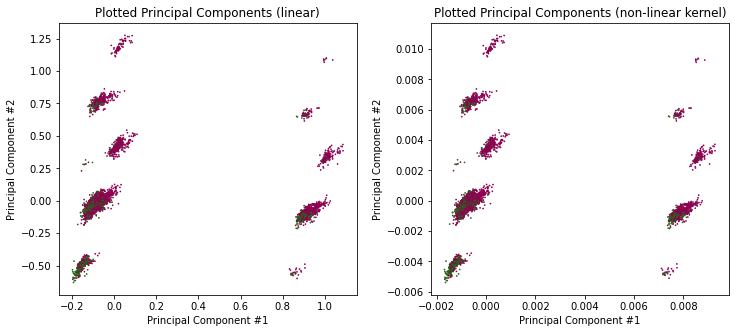

In [52]:
# plot 1st and 2nd components
fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.subplots_adjust(wspace=0.25)
ax[0].scatter(pdata[:,0], pdata[:,1], s=0.5, c=headline_labels, cmap='PiYG')
ax[0].title.set_text("Plotted Principal Components (linear)")
ax[0].set_xlabel("Principal Component #1")
ax[0].set_ylabel("Principal Component #2")
ax[1].scatter(kpdata[:,0], kpdata[:,1], s=0.5, c=headline_labels, cmap='PiYG')
ax[1].title.set_text("Plotted Principal Components (non-linear kernel)")
ax[1].set_xlabel("Principal Component #1")
ax[1].set_ylabel("Principal Component #2")

Just from eyeballing the two plots, it would appear that the non-linear PCA representation (which leveraged the radial basis kernel function) is identical to the linear PCA version, though with a slightly different scale. This suggests to me that it's probably fine going with the linear representation. Additionally, there already appear to be clusters in the data after reducing to 2 dimensions.

In this case, color represents the point's true label. Colors are interspersed within each cluster, with no clear decision boundary visible. This suggests a harder classification task at hand. 

To get a sense of whether we should use these reduced representations, let's take a look at the explained variance:

In [53]:
print(f"Variance explained by 1st and 2nd principal components, respectively: {round(pca.explained_variance_[0]*100, 2)}%, {round(pca.explained_variance_[1]*100, 2)}%")

Variance explained by 1st and 2nd principal components, respectively: 8.38%, 4.01%


In all, linear PCA with 2 components only explains 12% of the total variance within the dataset, which makes me think we should avoid using this method if possible. This isn't totally unexpected, given the bag-of-words model contains ~27,000 values.

### Model fitting and analysis

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(headline_array, headline_labels, np.arange(len(headline_array)), test_size=0.3, random_state=69)

nb = GaussianNB()
nb.fit(X_train, y_train)
nb_score = nb.score(X_test, y_test)

logreg = LogisticRegression(random_state=55)
logreg.fit(X_train, y_train)
logreg_score = logreg.score(X_test, y_test)

# determining the ideal number of neighbors for our k-nearest neighbor model
neighbors = {'n_neighbors': np.arange(1,5)}
knn = GridSearchCV(KNeighborsClassifier(), neighbors, cv=5, scoring='accuracy') # leverage 10-fold cross-validation to confirm neighbor
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
knn.best_params_

{'n_neighbors': 2}

After testing 1 up through 5 nearest neighbors for the KNN model, the ideal number of neighbors, based upon classification accuracy, is 2.

In [55]:
forest = RandomForestClassifier(n_estimators=13, random_state=9)
forest.fit(X_train, y_train)
forest_score = forest.score(X_test, y_test)

test_scores = {'Classifier': ['Naive Bayes', 'Logistic Regression', 'K-nearest Neighbor', 'Random Forest'], 'Test Accuracy':[nb_score, logreg_score, knn_score, forest_score]}
df_scores = pd.DataFrame(test_scores)
df_scores['Test Accuracy'] = round(df_scores['Test Accuracy'], 2)
df_scores

,Classifier,Test Accuracy
0,Naive Bayes,0.62
1,Logistic Regression,0.83
2,K-nearest Neighbor,0.45
3,Random Forest,0.79


## Evaluation and Final Results

With the principal evaluation metric being testing accuracy (number correct out of all test points), logistic regression takes the cake (see table above). If I had to venture a guess as to why this was the case, it could be due to the fact that logistic regression assigns probabilities to labels and thus performs better when there's a less-clear distinction between classes. That's certainly the case with this dataset, as evidenced by the PCA representation. The random forest accuracy rate of 79% isn't far behind, and the discrepancy between the two could very well be chalked up to the random train/test split. The Naive Bayes and K-nearest neighbor classifiers performed substantially worse. The accuracy for the latter could've potentially been improved had I tested additional numbers of neighbors. 

An accuracy rate of 83% isn't bad, though I'd hoped for better. There are undoubtedly actions that could be taken to improve upon this, which I will expound upon later on.

### Potential bias?

Although the 2-component representation of the data only represents 12% of the total variance in the dataset, the clusters in the plot this still suggests to me that there is likely some bias within the dataset, specifically in the headlines that weren't from "The Onion". My suspicion coming in was that more sensational headlines made up this class of non-Onion headlines, to make the classification task more difficult. This of course isn't truly representative of all non-Onion headlines. Some non-Onion headlines include: 

* Former Belgian King fined $5k a day until he takes Paternity test

* 'Seductive' dress gets girl barred from chess tournament

* No, Seriously. A Goat Arrested, Then Gets Bail In Chhattisgarh

Had time permitted, I would've like to have added 'less sensational' data points to the dataset. 

On the other hand, if we assume the dataset is actually irregularly shaped, it would've been ideal to explore more non-linear methods of classification. I would've also like to have investigated AdaBoost. 

### Opportunities for further improvement

Improvement in test accuracy would likely come as a result of a few actions. For one, there are certainly more things that could be done to initially clean the data and reduce the number of features, thereby reducing computational time. The specific recommendations are as follows:

1. Standardize numeric representation--either convert all numbers to a word representation (i.e. 9 → nine) or visa versa.

2. Expand the definition of 'stop word' to further hone the list of accepted words. Excluding, for example, 'can't' and 'would'

3. Consolidating word tenses to a single representation. For example, "ran," "run," and "running" could be consolidated to the present tense "run", thus reducing our feature vector further.

4. Tag all compound/proper nouns--I only did so for those most frequently occurring

Had time permitted, I would've also liked to have expanded hyperparameter tuning. For the K-nearest neighbor model, I was only able to test models that utilized up to 5-nearest neighbors for classification, while upwards of 50 would've been preferred. For the logistic regression model, I would've enjoyed manipulating the penalty parameter (used L2) and manipulating the regularization strength with the C hyperparameter (utilized 1.0). And for the random forest model, I limited the number of trees used to 13 to reduce computational time. It would've been interesting to both expand the number of trees used and examine the O.O.B. error as the number of trees used increased. 

Another interesting avenue would've been the generation of confusion matrices for each model. In my view, it's likely worse to not classify a headline that is indeed from "The Onion" than to label real news as Onion-generated. This could very well impact which classification model is deemed "better."